<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Linking SURF 2020-2023**

In this Notebook, we will use the linking questions from the SURF survey to connect students' responses over the 4 year period.

**2020/2021 Linking Questions**
- SBJ.FCT.Link.BirthMonth
- SBJ.FCT.Link.OlderSiblings
- SBJ.FCT.Link.EyeColor
- SBJ.FCT.Link.MiddleInitial
- SBJ.CHR.Link.Streetname
- SBJ.INT.Link.KindergartenYearEst

**2022/2023 Linking Questions**
- SBJ.FCT.Link.BirthMonth
- SBJ.FCT.Link.Name3rdLetter (additional)
- SBJ.FCT.Link.OlderSiblings
- SBJ.FCT.Link.EyeColor
- SBJ.FCT.Link.MiddleInitial
- SBJ.CHR.Link.Streetname
- SBJ.INT.Link.KindergartenYearEst

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

### **Linking SURF 2020 and 2021 Responses**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

In [4]:
# Read data
surf2020 = pd.read_csv("data/SY2020.csv")
surf2021 = pd.read_csv("data/SY2021.csv")

/var/folders/sk/hy6bzzbx4rd98zc284jmxmkm0000gn/T/ipykernel_4428/2826611207.py:3: DtypeWarning: Columns (129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  surf2021 = pd.read_csv("data/SY2021.csv")


In [3]:
linking_qs = [
    "SBJ.FCT.Link.BirthMonth",
    "SBJ.FCT.Link.OlderSiblings",
    "SBJ.FCT.Link.EyeColor",
    "SBJ.FCT.Link.MiddleInitial",
    "SBJ.CHR.Link.Streetname",
    "SBJ.INT.Link.KindergartenYearEst"
]

In [4]:
surf2020_cleaned = surf2020.dropna(subset=linking_qs)
surf2021_cleaned = surf2021.dropna(subset=linking_qs)

print("SURF2020 Cleaned")
print(surf2020_cleaned[linking_qs].isnull().sum())
print("\nSURF2021 Cleaned")
print(surf2021_cleaned[linking_qs].isnull().sum())

SURF2020 Cleaned
SBJ.FCT.Link.BirthMonth             0
SBJ.FCT.Link.OlderSiblings          0
SBJ.FCT.Link.EyeColor               0
SBJ.FCT.Link.MiddleInitial          0
SBJ.CHR.Link.Streetname             0
SBJ.INT.Link.KindergartenYearEst    0
dtype: int64

SURF2021 Cleaned
SBJ.FCT.Link.BirthMonth             0
SBJ.FCT.Link.OlderSiblings          0
SBJ.FCT.Link.EyeColor               0
SBJ.FCT.Link.MiddleInitial          0
SBJ.CHR.Link.Streetname             0
SBJ.INT.Link.KindergartenYearEst    0
dtype: int64


In [5]:
surf2020_cleaned = surf2020_cleaned.reset_index()
surf2021_cleaned = surf2021_cleaned.reset_index()

In [6]:
for col in surf2020.columns:
    print(col)

IDX.INT.Origin.Record
IDX.INT.Origin.Database
SSS.INT.School.Code
SSS.CHR.GradesSurveyed
SSS.INT.Fifth.Grade.Enrollment
SSS.INT.Sixth.Grade.Enrollment
SSS.INT.Seventh.Grade.Enrollment
SSS.INT.Eighth.Grade.Enrollment
SSS.INT.Ninth.Grade.Enrollment
SSS.INT.Tenth.Grade.Enrollment
SSS.INT.Eleventh.Grade.Enrollment
SSS.INT.Twelfth.Grade.Enrollment
SSS.INT.Grade
SSS.INT.Cohort
SSS.INT.Age
SSS.DBL.Completion.SY20.SY21
SSS.DTM.Survey
SSS.DTM.ContactPage
SSS.INT.SurveyYear
SSS.INT.District.Code
SBJ.FCT.Sex
SBJ.FCT.GenderId
SBJ.CHR.Gender.Other
SBJ.LGL.Race.White
SBJ.LGL.Race.HaitianBlackAfricanAmerican
SBJ.LGL.Race.Asian
SBJ.LGL.Race.HawaiianPacificIslander
SBJ.LGL.Race.AmericanIndianAlaskaNative
SBJ.LGL.Race.MiddleEasternNorthAfrican
SBJ.LGL.Race.Other
SBJ.LGL.Race.Multiple
SBJ.FCT.Race
SBJ.FCT.Ethnicity
SBJ.FCT.Sexuality
SBJ.CHR.SexualOrientation.Other
SBJ.FCT.Link.BirthMonth
SBJ.FCT.Link.OlderSiblings
SBJ.FCT.Link.EyeColor
SBJ.FCT.Link.MiddleInitial
SBJ.CHR.Link.Streetname
SBJ.INT.Link.Kinde

_______________________

#### **Linking Questions**

As shown in the paper *Understanding Adolescent Mental Health Symptom Progression in School-Based Settings: The Substance Use and Risk Factors (SURF) Survey*, allowing one-off errors ("one-missing" subsets) in the set of linking questions led to an substantially improved the true positive rate while only slightly diminishing the true negative rate. Additionally, students were reported to answer the eye color, street name questions, and older sibling question least consistently, and the simulated experiment showed that including a subset of questions leaving off street name and eye color lead to the best balance between the true positive and true negative rate.


In [6]:
# Acceptable linking subsets
link_subsets = [linking_qs] + list(combinations(linking_qs, 5))
link_subsets.append([
    "SBJ.FCT.Link.BirthMonth",
    "SBJ.FCT.Link.OlderSiblings",
    "SBJ.FCT.Link.MiddleInitial",
    "SBJ.INT.Link.KindergartenYearEst"
])
for i in range(len(link_subsets)):
    link_subsets[i] = list(link_subsets[i])

In [7]:
# For plotting
def create_linker(df, linked_subsets):
    """
    Returns a helper function to find the first matching observation in the DataFrame.

    Input:
        df (pd.DataFrame): The DataFrame to search in.
        link_subsets (list of list): List of subsets of column names to check.

    Output:
        function: A helper function that takes `obs` as input and returns the first matching observation.
    """
    
    # For plotting purposes
    matches_counts = defaultdict(int)
    subset_sizes = defaultdict(int)
    gen_counts = defaultdict(int)
    linked_ids = set()
    
    # Find link
    def find_link(obs):
        for i, subset in enumerate(linked_subsets):
            match = df[df[subset].eq(obs[subset]).all(axis=1)]
            if not match.empty:
                matches_counts[len(match)] += 1
                subset_sizes[len(subset)] += 1
                gen_counts[len(match) * 10 + len(subset)] += 1
                for i in range(len(match)):
                    if match.iloc[i]["index"] not in linked_ids:
                        linked_ids.add(match.iloc[i]["index"])
                        return match.iloc[0]["index"]
        return None
    
    return find_link, matches_counts, subset_sizes, gen_counts, linked_ids

In [8]:
find_link, matches_counts, subset_sizes, gen_counts, linked_ids = create_linker(surf2021_cleaned, link_subsets)

# Augment data with link matches
surf2020_cleaned["SBJ.CHR.Matched.ID"] = surf2020_cleaned.apply(find_link, axis=1)
surf2020_cleaned["SBJ.LGL.Matched.ID"] = surf2020_cleaned["SBJ.CHR.Matched.ID"].notnull()

In [9]:
print(matches_counts)
print(subset_sizes)
print(gen_counts)

defaultdict(<class 'int'>, {1: 2557, 2: 210, 3: 100, 4: 44, 7: 14, 5: 14, 8: 5, 6: 9, 9: 2})
defaultdict(<class 'int'>, {6: 1378, 5: 1253, 4: 324})
defaultdict(<class 'int'>, {16: 1358, 15: 1035, 14: 164, 26: 19, 25: 123, 35: 62, 45: 23, 34: 38, 24: 68, 75: 5, 54: 12, 44: 21, 74: 9, 86: 1, 64: 6, 65: 3, 94: 2, 84: 4, 55: 2})


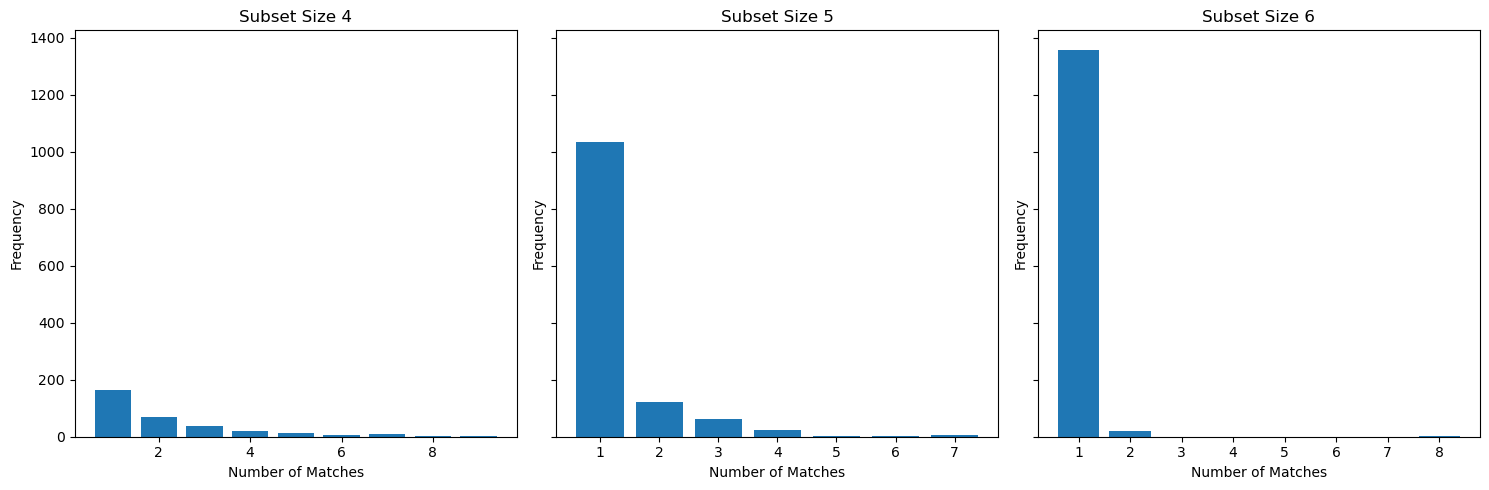

In [10]:
matches = [(key // 10, key % 10, value) for key, value in gen_counts.items()]
subset_sizes = [4, 5, 6]
data_by_subset = {size: [] for size in subset_sizes}

for match_count, subset_size, freq in matches:
    if subset_size in subset_sizes:
        data_by_subset[subset_size].append((match_count, freq))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, subset_size in enumerate(subset_sizes):
    ax = axes[i]
    data = data_by_subset[subset_size]
    if data:
        match_counts, frequencies = zip(*data)
        ax.bar(match_counts, frequencies)
        ax.set_title(f"Subset Size {subset_size}")
        ax.set_xlabel("Number of Matches")
        ax.set_ylabel("Frequency")
    else:
        ax.set_title(f"Subset Size {subset_size}")
        ax.set_xlabel("Number of Matches")
        ax.set_ylabel("Frequency")
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [11]:
new_size = surf2020_cleaned["SBJ.LGL.Matched.ID"].sum()
old_size = len(surf2020_cleaned)

print("Total linked:", new_size)
print("Original dataset size:", old_size)
print("Number lost:", old_size - new_size)

Total linked: 2298
Original dataset size: 3430
Number lost: 1132


In [12]:
surf2020_linked = surf2020_cleaned[surf2020_cleaned["SBJ.LGL.Matched.ID"] == True]
surf2021_linked = surf2021_cleaned[surf2021_cleaned["index"].isin(linked_ids)]

assert(len(surf2021_linked) == new_size)
print("Successful link!")

Successful link!
